# PART 3: SUPERVISED LEARNING; GENERALIZATION AND OVERFITTING; DECISION TREE

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is 
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd
from collections import Counter

from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc, precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from collections import Counter
from numpy import where
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

LOADING DATA SET AND FEATURE SELECTION

In [2]:

# The Data is uploaded to Notebook in csv file, 
# we will store it in dataFrame (transactions) using pandas read_csv method
# in this Nootebook we will be analysing Test Data generated for credit card fraud.
# This Data is downloded from kaggle from this link: https://www.kaggle.com/ealaxi/paysim1

# Loading config files
import json
with open('config.json', 'r') as f:
    config = json.load(f)

# Loading datasets using pandas to variable 'transactions'
transactions = pd.read_csv(config['Training_Dataset'])

# normalize dataset
import helper
# remoing unnecessary attributes that wont be used in our clustering
transactions = helper.preprocessDataset(transactions)

#transactions_in_24hrs = transactions[transactions['step'] < 13]

transactions.head()


# checking data size after normalization
#transactions.describe()
#transactions.info(memory_usage = "deep")

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0.0,218015.85,863.00,0.0,905136.36,843495.76,0
1,0.0,229518.37,20528.00,0.0,786.00,0.00,0
2,0.0,19707.44,289451.64,269744.2,3509020.91,3622590.61,0
3,0.0,82741.31,24543.00,0.0,6845.06,89586.37,0
4,1.0,30674.98,30674.98,0.0,0.00,0.00,1


# DECISION TREEE CLASSIFICATION

TASK 1: PREPARING TEST AND TRAIN DATASETS

In [3]:
# get X and y
X = transactions.iloc[:, :-1]
y = transactions.isFraud


# scale dataset to scale outliers
# scaler = MinMaxScaler()
#scaler.fit(X)
#X = scaler.transform(X)

# split dataset to test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y, shuffle=True)


Now that we have splited our dataset to train and test, and we know we have unbalanced dataset, using this will make classifier bias towards majority class and produces inflated performance measures which are not accurate, to avoid this we need to balance or dataset by either undersampling to minority class or oversampling to majority class.

So we will use RandomUndersampler from imblearn library to undersamply only train dataset and test later the classifier with the original unbalanced test data, we will be using class_weight=balanced in deceision tree to make sure classes are distributed when training our classifier

In [4]:
# balancing only train sets seperately to avoid feature leaking
X_train, y_train = helper.balanceDataSet(X_train, y_train, 'undersample')

TASK 2: RUN DECISION TREE CLASSIFIER ON TRAIN DATASET AND MEASURE ACCURACY

TASK 2.1: Running the decision tree classifier on training set

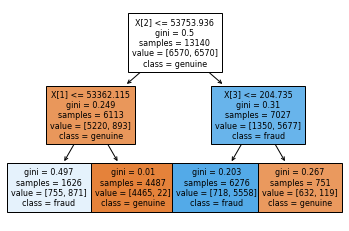

In [5]:
# Train Classifier
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight='balanced')
tree_clf.fit(X_train, y_train)
plot_tree(tree_clf, class_names =["genuine", "fraud"], filled = True, fontsize='8')
plt.show()

TASK 2.2: Calculating Accuracy using same training set

In [6]:
y_pred = tree_clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      6570
           1       0.81      0.98      0.89      6570

    accuracy                           0.88     13140
   macro avg       0.89      0.88      0.88     13140
weighted avg       0.89      0.88      0.88     13140



TASK 2.3: Measurment of the  accuracy  on  the  training  set  using  10-fold  cross-validation.

In [7]:
#from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
#from numpy import mean
#cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#cv = KFold(n_splits=10, shuffle=True, random_state=10)
#scores = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=cv)
#scores = []
#for train_index, test_index in cv.split(X_train, y_train):
     #print("TRAIN:", train_index, "TEST:", test_index)
#     train_X, test_X = X_train[train_index], X_train[test_index]
#     train_y, test_y = y_train[train_index], y_train[test_index]
	
#     dtclf = DecisionTreeClassifier()
#     dtclf.fit(train_X, train_y)
     #y_pred = dtclf.predict(X_test)
     #display_measures(y_test, y_pred)
#     scores.append(dtclf.score(test_X, test_y))
# print("scores after apply 10 fold cross validation: ",scores)
# print("accuracy after apply 10 fold cross validation: ",mean(scores))

In [7]:
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from numpy import mean
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)#KFold(n_splits=10, shuffle=True, random_state=10)
model = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight='balanced') 

results = cross_validate(estimator=model, X=X_train, y=y_train, cv=kfold, scoring=scoring)
#print(results)
print("accuracy: ", mean(results['test_accuracy']))
print("precision: ", mean(results['test_precision']))
print("recall: ", mean(results['test_recall']))
print("f1_score: ", mean(results['test_f1_score']))

accuracy:  0.8766362252663622
precision:  0.8132546727101868
recall:  0.9779299847792998
f1_score:  0.8879947488619019


Observations:

With 10 fold cross validation, we observe that accuracy droped alittle fro 0.88 to 0.87, something to notice here is recal is improving in this experiment, overall this shows that our model is still overfitting even after 10 fold cross validation

TASK 3: Using  training  and  testing  data  sets  instead  of  the  cross validation.

In [8]:
split_tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight='balanced')
split_tree_clf.fit(X_train, y_train)
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc, precision_score
y_test_pred = split_tree_clf.predict(X_test)

print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       1.00      0.78      0.87     18400
           1       0.28      0.97      0.44      1643

    accuracy                           0.79     20043
   macro avg       0.64      0.88      0.66     20043
weighted avg       0.94      0.79      0.84     20043



Observations: When we introduced new test data to our model it seems that it not doing wel in terms of occuracy, it went down to 0.79 from 0.88, this shows that the model doesnt generalize well to new data which is a symptom that our model may be overfitting

TASK 3: DECEISION TREE PARAMETER TUNING

In above experiment, we used max_depth = 2, let us tune this parameter and change it to 3 and see how it will do

In [9]:
dtclf = DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced')
dtclf.fit(X_train, y_train)
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc, precision_score
y_pred_dt = dtclf.predict(X_test)

print(classification_report(y_test, y_pred_dt))


              precision    recall  f1-score   support

           0       1.00      0.86      0.92     18400
           1       0.39      1.00      0.56      1643

    accuracy                           0.87     20043
   macro avg       0.69      0.93      0.74     20043
weighted avg       0.95      0.87      0.89     20043



Observations:

By just changing the max_depth to 3, model accuracy increased to 0.87 from 0.79, this shows that max_depth influencies classifier, the higher its value the better the accuracy and this is understandable as its fitting more deeply to the given dataset but that causes probably for model to perform perform poorly if introduced to new dataset

TASK 4: TRAIN-TEST RATIO

On this task, I will increase to 30% then to 60%, for this purpose I will create small method that will do splitting for me along with any preprocessing need on the train set.

For this we will use max_depth=2 as that is our base configurations

In [10]:
def split_dataset(test_ratio):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42, stratify=y, shuffle=True)
    
    # balancing only train sets seperately to avoid feature leaking
    X_train, y_train = helper.balanceDataSet(X_train, y_train)

    return X_train, X_test, y_train, y_test
    

Let us use test ratio 30% and see performance

In [11]:
X_train, X_test, y_train, y_test = split_dataset(0.3)
dtclf = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight='balanced')
dtclf.fit(X_train, y_train)
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc, precision_score
y_pred_dt = dtclf.predict(X_test)

print(classification_report(y_test, y_pred_dt))


              precision    recall  f1-score   support

           0       1.00      0.77      0.87     27600
           1       0.28      0.98      0.43      2464

    accuracy                           0.79     30064
   macro avg       0.64      0.87      0.65     30064
weighted avg       0.94      0.79      0.84     30064



Observations:

Score stayed @0.79 same as when test_size was 0.2

Let us use test ratio 60% and see scores

In [12]:
X_train, X_test, y_train, y_test = split_dataset(0.6)
dtclf = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight='balanced')
dtclf.fit(X_train, y_train)
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc, precision_score
y_pred_dt = dtclf.predict(X_test)

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88     55200
           1       0.28      0.98      0.44      4928

    accuracy                           0.80     60128
   macro avg       0.64      0.88      0.66     60128
weighted avg       0.94      0.80      0.84     60128



Observations:

It actually performed better with test_size 60% but this is not reliable as if we look in to the positive class precision and f1 score is not that good

TASK 5: Random forest Algorithm

For this task I will use Random forest classifier on same dataset and see how its performing comparing to decision tree

In [18]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = split_dataset(0.2)

rfclf = RandomForestClassifier(max_depth=2, random_state=42, class_weight='balanced')
rfclf.fit(X_train,y_train)

y_pred = rfclf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.95      0.96     18400
           1       0.56      0.78      0.65      1643

    accuracy                           0.93     20043
   macro avg       0.77      0.86      0.81     20043
weighted avg       0.95      0.93      0.94     20043



Observations:

This seems to be doing better than decision tree with same parameter, its accuracy reached to 0.93 as you can observe from above table, it is also interesting that percision and f1 score of positive class show significant improvement when compared to decison tree with same hyperparameter configurations

Let us now see how it performes when we increase test size to 60%

In [17]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = split_dataset(0.6)

rfclf = RandomForestClassifier(max_depth=2, random_state=42, class_weight='balanced')
rfclf.fit(X_train,y_train)

y_pred = rfclf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.94      0.96     55200
           1       0.53      0.78      0.63      4928

    accuracy                           0.93     60128
   macro avg       0.76      0.86      0.80     60128
weighted avg       0.94      0.93      0.93     60128



Observations:

Interestingly, percision for positive class decreased which is expected but dection tree was not performing it in he expected way.



Let us try and tune some of the other hyperparameters of RandomForest classifier such as: 'n_estimators' which tunes number of trees in the forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = split_dataset(0.2)

rfclf = RandomForestClassifier(max_depth=2, random_state=42, class_weight='balanced', n_estimators=15)
rfclf.fit(X_train,y_train)

y_pred = rfclf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.87      0.93     18400
           1       0.39      0.92      0.55      1643

    accuracy                           0.88     20043
   macro avg       0.69      0.90      0.74     20043
weighted avg       0.94      0.88      0.90     20043



Observations:

This hyperparameter influences classifier, as shown above it actually decreased the accuracy and the reason s abovious that by default RandomClassifier makes this parameter=100, when we choose it to be 15 it actually had an impact on the classifier's performance.

This hyperparameter is used to configure how many trees will be there in the forest

# Conclusion:
Decision Tree classifier  will do well with given dataset but it has two drawbacks that are corelated to each other:
1. It overfits to given dataset
2. It doesnt generalize well to new dataset

I have also used RandomForestClassifier, it seems to be doing better than Decision tree classifier but it also suffers from ovefitting and generalization